In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

import plotting

2024-10-04 18:23:59.821068: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-04 18:23:59.834248: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-04 18:23:59.838177: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-04 18:23:59.848906: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-04 18:24:00.574626: W tensorflow/compiler/tf2

In [2]:
# force gpu use
gpus = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_visible_devices(gpus[0], 'GPU')

I0000 00:00:1728055441.262751   10467 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1728055441.306782   10467 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1728055441.309076   10467 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


In [3]:
def setup_model() -> tf.keras.models.Sequential:
    @tf.function
    def custom_activation(x):
        return tf.sin(x)

    model = tf.keras.models.Sequential(
        [
            tf.keras.layers.Input((2,)),
            tf.keras.layers.Dense(units=32, activation=custom_activation),
            tf.keras.layers.Dense(units=32, activation=custom_activation),
            tf.keras.layers.Dense(units=32, activation=custom_activation),
            tf.keras.layers.Dense(units=1),
        ]
    )

    model.summary()
    model.compile(optimizer="Adam", loss="mean_squared_error")
    return model, tf.keras.optimizers.Adam(learning_rate=0.001)

$\frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2}=f$

In [4]:
tf_pi = tf.constant(np.pi)

# TODO: experiment with tf function and parameters
@tf.function
def f(x, y):
    return -2 * tf_pi * tf_pi * tf.sin(tf_pi * y) * tf.sin(tf_pi * x)

I0000 00:00:1728055441.358030   10467 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1728055441.360010   10467 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1728055441.361811   10467 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1728055441.479700   10467 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

### Params

In [5]:
grid_size = (50, 50)
plotting_grid_size = (200, 200)
x_limits = (0, 2)
y_limits = (0, 2)
border_grid_size = (50, 50)

EPOCHS = 3000
EPRINT = 500
LOSS = 1e-2  #1e-4

def checkpoint_path(ind: int) -> str:
    return f"../models/model{ind}.weights.h5"

def koef_path(koef: int) -> str:
    return f"../models/koef={koef}.weights.h5"

In [6]:
def get_area(grid_size, x_limits, y_limits):
    x = np.linspace(x_limits[0], x_limits[1], grid_size[0], dtype=np.float32)[1:-1]
    y = np.linspace(y_limits[0], y_limits[1], grid_size[1], dtype=np.float32)[1:-1]

    # FIXME: area inside points is in border??
    return mesh_to_pairs(np.meshgrid(x, y))


def get_border(border_grid_size, x_limits, y_limits):
    x = np.linspace(x_limits[0], x_limits[1],
                    border_grid_size[0], dtype=np.float32)
    y = np.linspace(y_limits[0], y_limits[1],
                    border_grid_size[1], dtype=np.float32)
    x_first = np.full(border_grid_size[0], x[0])
    x_last = np.full(border_grid_size[0], x[-1])
    y_first = np.full(border_grid_size[1], y[0])
    y_last = np.full(border_grid_size[1], y[-1])
    border = np.concatenate((np.column_stack((x_first, x)), np.column_stack(
        (x_last, x)), np.column_stack((y, y_first))[1:-1], np.column_stack((y, y_last))[1:-1]))
    return border


def mesh_to_pairs(meshgrid: list[np.ndarray]):
    return np.column_stack((meshgrid[0].flatten(), meshgrid[1].flatten()))

In [7]:
@tf.function
def ode_system(net, koef, coord, border):
    with tf.GradientTape(watch_accessed_variables=False, persistent=True) as tape:
        tape.watch(coord)
        with tf.GradientTape(watch_accessed_variables=False, persistent=True) as tape1:
            tape1.watch(coord)
            u = net(coord)
        grad_u = tape1.gradient(u, coord)
        du_dx = grad_u[..., 0]
        du_dy = grad_u[..., 1]
        del tape1

    d2u_dx2 = tape.gradient(du_dx, coord)[..., 0]
    d2u_dy2 = tape.gradient(du_dy, coord)[..., 1]
    del tape
    
    x = coord[..., 0]
    y = coord[..., 1]
    ode_loss = d2u_dx2 + d2u_dy2 - f(x, y)
    IC_loss = net(border) - tf.zeros((len(border), 1))

    # square_loss = tf.square(ode_loss) + koef * tf.square(IC_loss)
    # total_loss = tf.reduce_mean(square_loss)

    # return total_loss
    return tf.reduce_mean(tf.square(ode_loss)) + koef * tf.reduce_mean(tf.square(IC_loss))

In [8]:
# train model
@tf.function
def train_with_loss(net, optm, koef, train_coord, border):
    for itr in tf.range(0, EPOCHS):
        with tf.GradientTape() as tape:
            train_loss = ode_system(net, koef, train_coord, border)
            # TODO: tf.summary
            # train_loss_record.append(train_loss)

        grad_w = tape.gradient(train_loss, net.trainable_variables)
        optm.apply_gradients(zip(grad_w, net.trainable_variables))
        del tape

        if itr % EPRINT == 0:
            # USE TF.PRINT()!!!
            tf.print("epoch:", itr, "loss:", train_loss)  #.numpy())
            if train_loss < LOSS:
                break

In [9]:
model, optm = setup_model()
initial_weights = model.get_weights()
area = get_area(grid_size, x_limits, y_limits)
border = get_border(border_grid_size, x_limits, y_limits)

for i in range(3):
    model.set_weights(initial_weights)
    koef = i
    path = koef_path(koef)
    if os.path.isfile(path):
        try:
            model.load_weights(path)
        except:
            os.remove(path)
            os.mknod(path)
    else:
        os.mknod(path)

    train_with_loss(model, optm, koef, area, border)
    print("Training ended successfully\n")

    model.save_weights(checkpoint_path(i))
    # plotting.NNPlots.plotLoss(train_loss_record)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32)             │            96 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,241 (8.75 KB)

 Trainable params: 2,241 (8.75 KB)

 Non-trainable params: 0 (0.00 B)

epoch: 0 loss: 101.376587
epoch: 500 loss: 0.521280944
epoch: 1000 loss: 0.100550182
epoch: 1500 loss: 0.0399697423
epoch: 2000 loss: 0.0220527016
epoch: 2500 loss: 0.0140867038
Training ended successfully

epoch: 0 loss: 101.482224
epoch: 500 loss: 0.393888593
epoch: 1000 loss: 0.195906818
epoch: 1500 loss: 0.109994784
epoch: 2000 loss: 0.065400064
epoch: 2500 loss: 0.0398200266
Training ended successfully

epoch: 0 loss: 101.58786
epoch: 500 loss: 0.271310478
epoch: 1000 loss: 0.0779647
epoch: 1500 loss: 0.0329352058
epoch: 2000 loss: 0.0144063346
epoch: 2500 loss: 0.00695166225
Training ended successfully



In [10]:
def real_u(area):
    area = np.array(area)
    if len(area.shape) >= 3:
        x = area[0]
        y = area[1]
        return np.sin(np.pi * x) * np.sin(np.pi * y)
    else:
        return np.array([np.sin(np.pi * x) * np.sin(np.pi * y)  for x, y in area])

In [11]:
"""
Preparing usefull arrays for plotting and accuracy calculation
"""

# TODO: set area and border in different arrays
x = np.linspace(x_limits[0], x_limits[1], plotting_grid_size[0])
y = np.linspace(y_limits[0], y_limits[1], plotting_grid_size[1])
x, y = np.meshgrid(x, y)
test_x = np.linspace(x_limits[0], x_limits[1], plotting_grid_size[0])
test_y = np.linspace(x_limits[0], x_limits[1], plotting_grid_size[1])
test_x, test_y = np.meshgrid(test_x, test_y)
train_u = real_u((x, y))
true_u = real_u((test_x, test_y))
test_coord = np.column_stack((test_x.flatten(), test_y.flatten()))
pred_coord = list()
for _x in x[0]:
    for _y in x[0]:
        pred_coord.append([_x, _y])
pred_u = model.predict(np.array(pred_coord)).ravel().reshape(plotting_grid_size[0], plotting_grid_size[1])

I0000 00:00:1728055469.267291   10522 service.cc:146] XLA service 0x7f25140164c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1728055469.267325   10522 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Laptop GPU, Compute Capability 8.6
2024-10-04 18:24:29.279516: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


 246/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 614us/step

I0000 00:00:1728055469.614835   10522 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


ValueError: not enough values to unpack (expected 3, got 2)

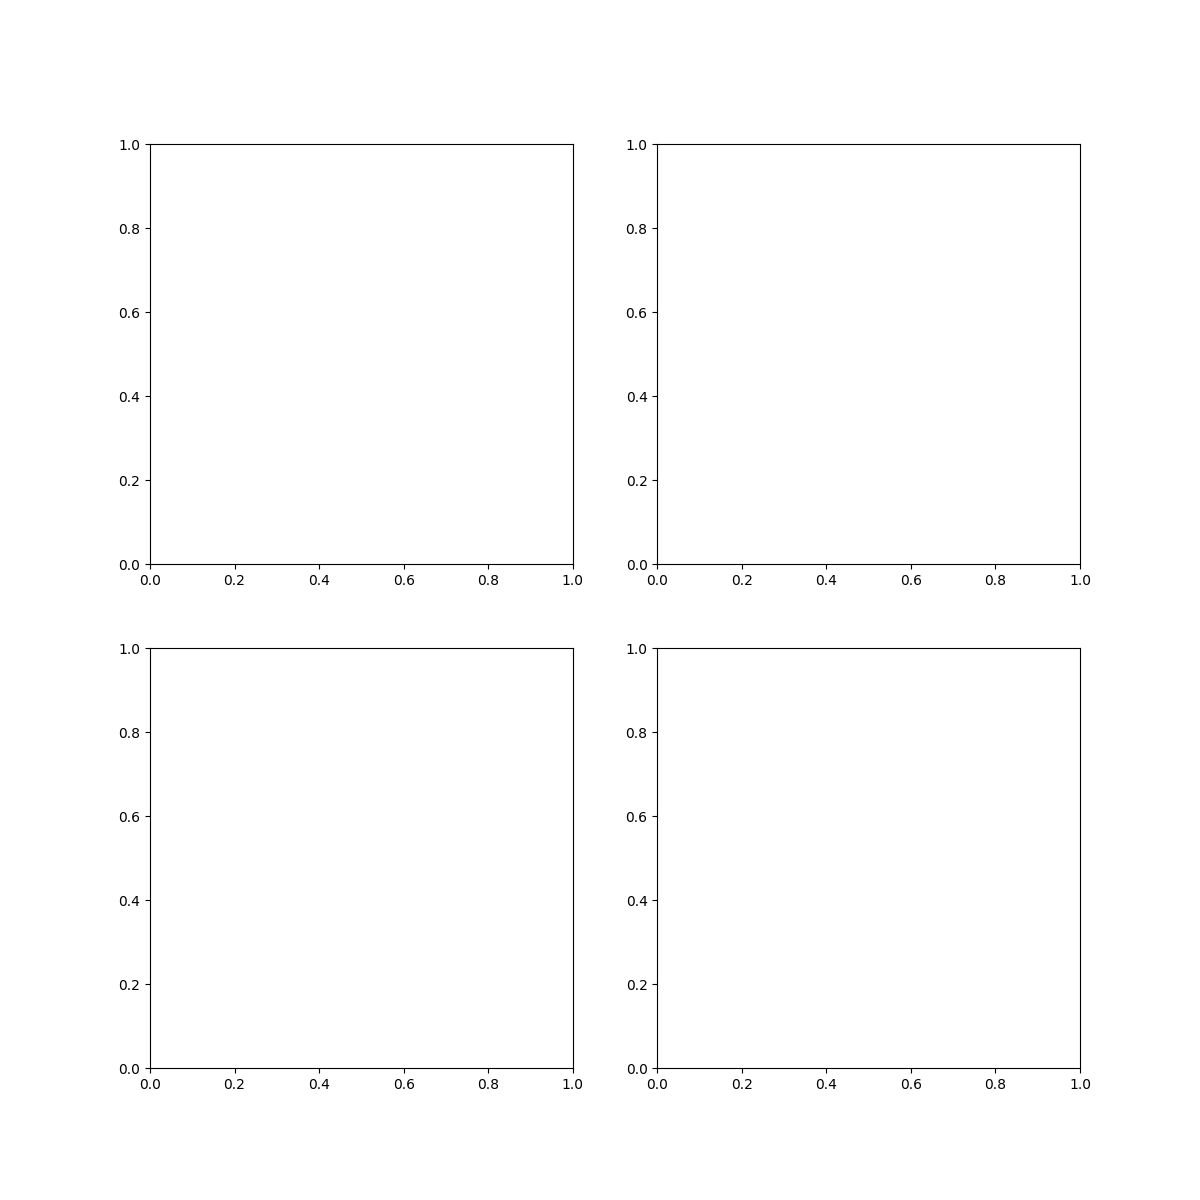

In [12]:
%matplotlib widget
plotter = plotting.NNPlots(test_x, test_y, true_u, x, y, pred_u, x_limits, y_limits)
# plotter.plot3d()
# plotter.plot2d_fix_x(3)

# cool cmaps: coolwarm(set as default), cool, gistncar, rainbow
plotter.plot2d_contour(color_map="gist_ncar", contour_levels=30)

# Accuracy calculation

In [32]:
from accuracy import AccuracyCalc

# 0 koef has bad accuracy)
for i in range(3):
    model.load_weights(checkpoint_path(i))
    calc = AccuracyCalc(model, real_u, area=np.array(pred_coord))
    print("Error:", calc.mse())
    print("Error:", calc.maxe())

   1/1250 ━━━━━━━━━━━━━━━━━━━━ 21s 17ms/step

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 1s 563us/step
Error: 0.5811934228731588
Error: 2.8734850883483887
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 1s 533us/step
Error: 0.00018626773258717495
Error: 0.09686440229415894
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 1s 546us/step
Error: 0.0002224409522294462
Error: 0.0751945897936821
